In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Storage Parameters

In [11]:
Ts = 1/12
c = 20
eta = 0.9
### For Intelligent Storage Ratio
# case_template = 'Strategic/MC20/UC25ED1_Strategic_true_ratio{}_Seg1_BAW0_MC20.0'
# ratios = [round(i * 0.1, 1) for i in range(11)]

### For random bidding model seletction
case_template = 'Strategic/EDH/UC25ED{}_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1'
ratios = [1, 6, 13]

### For Future Cases
# case_template = 'Strategic/{}/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1'
# ratios = [2022]

# case = 'Strategic/MC20/Strategic/UC25ED1_Strategic_true_ratio0.3_Seg1_BAW0_MC20.0'
# case = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete'
# case = 'Strategic/BidAhead/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_BAW36'

### Price Stats

In [12]:
# Initialize lists to hold DataFrames
mean_prices_dfs = []
std_prices_dfs = []

In [13]:
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(ratio)
    try:
        # Try to read the CSV file for the current case
        price = pd.read_csv('output/'+case+'/EDprice.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        continue

    # Calculate stats and transpose
    pricestats = pd.concat([price.mean()*12, (price*12).std()], axis=1).T

    # Now, instead of appending Series objects, you create DataFrame slices for each and append them
    mean_prices_dfs.append(pricestats.iloc[[0]])
    std_prices_dfs.append(pricestats.iloc[[1]])

In [14]:
# Convert lists of series to DataFrames
mean_prices_df = pd.concat(mean_prices_dfs).reset_index(drop=True)
std_prices_df = pd.concat(std_prices_dfs).reset_index(drop=True)
mean_prices_df.index = ratios
std_prices_df.index = ratios

In [15]:
mean_prices_df

,0,1,2,3,4,5,6
1,67.326451,73.191132,57.676745,92.610836,65.929798,58.624840,69.853270
6,67.361423,73.076897,57.534735,92.257701,66.000303,58.599950,69.664381
13,67.522274,73.214699,58.085360,92.569431,66.166643,58.956148,70.116527


In [16]:
std_prices_df

,0,1,2,3,4,5,6
1,45.062813,51.630658,48.033713,489.073450,44.787844,46.580289,68.383252
6,45.642730,52.380174,48.086465,487.613518,45.343527,46.737260,68.301577
13,46.174169,53.264460,49.185915,487.059701,45.788535,47.676846,68.830779


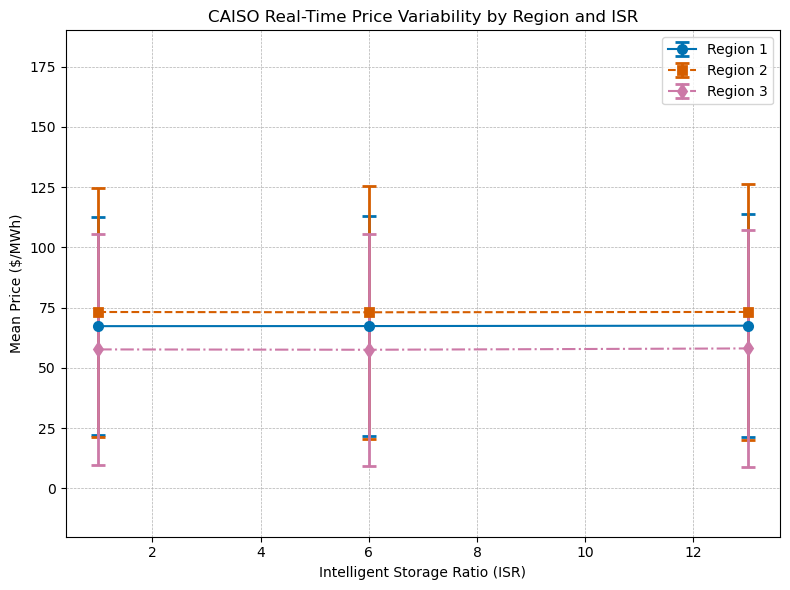

In [17]:
# Selecting the columns for Regions 1, 2, and 3
regions = [0, 1, 2]
mean_prices = mean_prices_df.iloc[:, regions]
std_prices = std_prices_df.iloc[:, regions]

# Preparing ISR values from the index
isr_values = mean_prices.index

# New colors and error bar theme
new_colors = ['#0072B2', '#D55E00', '#CC79A7']  # Updated color palette
new_labels = ['Region 1', 'Region 2', 'Region 3']
line_styles = ['-', '--', '-.']  # Different line styles for visual distinction
marker_styles = ['o', 's', 'd']  # Different marker styles for each region
plt.figure(figsize=(8, 6))


for region, color, label, line_style, marker_style in zip(regions, new_colors, new_labels, line_styles, marker_styles):
    plt.errorbar(isr_values, mean_prices.iloc[:, region], yerr=std_prices.iloc[:, region], 
                 label=label, color=color, fmt=line_style + marker_style, capsize=5, elinewidth=2, capthick=2, markeredgewidth=2)

plt.title('CAISO Real-Time Price Variability by Region and ISR')
plt.xlabel('Intelligent Storage Ratio (ISR)')
plt.ylabel('Mean Price ($/MWh)')
plt.ylim([-20,190])
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


# Save the plot to a file suitable for inclusion in your paper
# plt.savefig('/mnt/data/caiso_price_variability.png', dpi=300)

# Show the plot
plt.show()


### Total System Cost

In [18]:
total_system_costs = []
# Loop over ratios from 0.0 to 1.0 (assuming increment by 0.1)
for ratio in ratios:
    case = case_template.format(ratio, ratio)
    try:
        # Read the CSV file for the current case
        cost = pd.read_csv(f'output/{case}/EDcost.csv', header=None)
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        # Optionally, append a NaN or some indicator of missing data
        total_system_costs.append(float('nan'))
        continue

    # Sum the total cost and normalize
    total_cost_normalized = cost.sum().values[0] / (10**10)
    total_system_costs.append(total_cost_normalized)

# Convert the list to a DataFrame
total_system_costs_df = pd.DataFrame(total_system_costs, columns=['Total System Cost'])

# Adjust the index to represent ratios directly, if desired
# total_system_costs_df.index = [str(round(i * 0.1, 1)) for i in range(11)]
total_system_costs_df.index = ratios


total_system_costs_df

,Total System Cost
1,2.804723
6,2.802749
13,2.802329


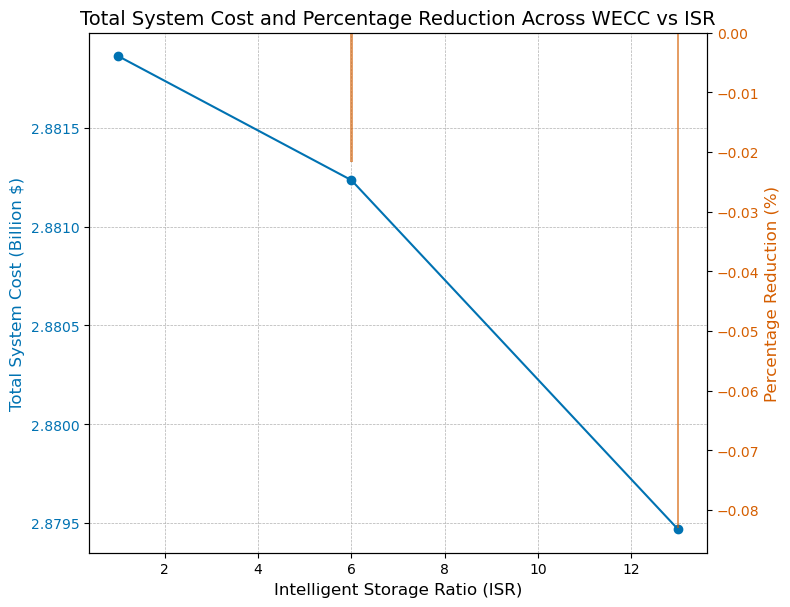

In [10]:
# Calculate percentage reduction compared to 0.0 ISR
initial_cost = total_system_costs_df['Total System Cost'].iloc[0]
percentage_reduction = (total_system_costs_df['Total System Cost'] - initial_cost) / initial_cost * 100

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

color = '#0072B2'
ax1.set_xlabel('Intelligent Storage Ratio (ISR)', fontsize=12)
ax1.set_ylabel('Total System Cost (Billion $)', color=color, fontsize=12)
ax1.plot(ratios, total_system_costs_df['Total System Cost'], '-o', color=color, label='Total System Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Instantiate a second y-axis for percentage reduction
ax2 = ax1.twinx() 
color = '#D55E00'
ax2.set_ylabel('Percentage Reduction (%)', color=color, fontsize=12)  
ax2.bar(ratios, percentage_reduction, width=0.05, color=color, alpha=0.6, label='Percentage Reduction')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Total System Cost and Percentage Reduction Across WECC vs ISR', fontsize=14)
plt.show()


### Storage Profit & Utilization (Aggregated ISR 0.1-0.9)

In [ ]:
# case = 'Strategic/MC20/UC25ED1_Strategic_true_ratio0.9_Seg5_BAW0_MC20.0'
case = 'Strategic/EDH6/UC25ED6_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1'


ESD = pd.read_csv('output/'+case+'/EDESD.csv',header=None)
ESC = pd.read_csv('output/'+case+'/EDESC.csv',header=None)
price = pd.read_csv('output/'+case+'/EDprice.csv',header=None)
ES = pd.read_csv('output/'+case+'/Strategic/ADDED_ES.csv')

In [ ]:
data = [
    ['S1', sum((ESD[35]-ESC[35])*price[0])/1000, sum((ESD[35]-ESC[35])*price[0] - Ts*c*ESD[35])/1000, sum((ESD[35]-ESC[35])*price[0] - Ts*c*ESD[35])/1000/ES['ESOC'][0], sum(ESD[35])/eta*Ts/ES['ESOC'][0]],
    ['NS1', sum((ESD[36]-ESC[36])*price[0])/1000, sum((ESD[36]-ESC[36])*price[0] - Ts*c*ESD[36])/1000, sum((ESD[36]-ESC[36])*price[0] - Ts*c*ESD[36])/1000/ES['ESOC'][1], sum(ESD[36])/eta*Ts/ES['ESOC'][1]],
    ['S2', sum((ESD[37]-ESC[37])*price[1])/1000, sum((ESD[37]-ESC[37])*price[1] - Ts*c*ESD[37])/1000, sum((ESD[37]-ESC[37])*price[1] - Ts*c*ESD[37])/1000/ES['ESOC'][2], sum(ESD[37])/eta*Ts/ES['ESOC'][2]],
    ['NS2', sum((ESD[38]-ESC[38])*price[1])/1000, sum((ESD[38]-ESC[38])*price[1] - Ts*c*ESD[38])/1000, sum((ESD[38]-ESC[38])*price[1] - Ts*c*ESD[38])/1000/ES['ESOC'][3], sum(ESD[38])/eta*Ts/ES['ESOC'][3]],
    ['S3', sum((ESD[39]-ESC[39])*price[2])/1000, sum((ESD[39]-ESC[39])*price[2] - Ts*c*ESD[39])/1000, sum((ESD[39]-ESC[39])*price[2] - Ts*c*ESD[39])/1000/ES['ESOC'][4], sum(ESD[39])/eta*Ts/ES['ESOC'][4]],
    ['NS3', sum((ESD[40]-ESC[40])*price[2])/1000, sum((ESD[40]-ESC[40])*price[2] - Ts*c*ESD[40])/1000, sum((ESD[40]-ESC[40])*price[2] - Ts*c*ESD[40])/1000/ES['ESOC'][5], sum(ESD[40])/eta*Ts/ES['ESOC'][5]],
    ['S4', sum((ESD[41]-ESC[41])*price[3])/1000, sum((ESD[41]-ESC[41])*price[3] - Ts*c*ESD[41])/1000, sum((ESD[41]-ESC[41])*price[3] - Ts*c*ESD[41])/1000/ES['ESOC'][6], sum(ESD[41])/eta*Ts/ES['ESOC'][6]],
    ['NS4', sum((ESD[42]-ESC[42])*price[3])/1000, sum((ESD[42]-ESC[42])*price[3] - Ts*c*ESD[42])/1000, sum((ESD[42]-ESC[42])*price[3] - Ts*c*ESD[42])/1000/ES['ESOC'][7], sum(ESD[42])/eta*Ts/ES['ESOC'][7]],
    ['S5', sum((ESD[43]-ESC[43])*price[4])/1000, sum((ESD[43]-ESC[43])*price[4] - Ts*c*ESD[43])/1000, sum((ESD[43]-ESC[43])*price[4] - Ts*c*ESD[43])/1000/ES['ESOC'][8], sum(ESD[43])/eta*Ts/ES['ESOC'][8]],
    ['NS5', sum((ESD[44]-ESC[44])*price[4])/1000, sum((ESD[44]-ESC[44])*price[4] - Ts*c*ESD[44])/1000, sum((ESD[44]-ESC[44])*price[4] - Ts*c*ESD[44])/1000/ES['ESOC'][9], sum(ESD[44])/eta*Ts/ES['ESOC'][9]],
    ['S6', sum((ESD[45]-ESC[45])*price[5])/1000, sum((ESD[45]-ESC[45])*price[5] - Ts*c*ESD[45])/1000, sum((ESD[45]-ESC[45])*price[5] - Ts*c*ESD[45])/1000/ES['ESOC'][10], sum(ESD[45])/eta*Ts/ES['ESOC'][10]],
    ['NS6', sum((ESD[46]-ESC[46])*price[5])/1000, sum((ESD[46]-ESC[46])*price[5] - Ts*c*ESD[46])/1000, sum((ESD[45]-ESC[45])*price[5] - Ts*c*ESD[46])/1000/ES['ESOC'][11], sum(ESD[46])/eta*Ts/ES['ESOC'][11]],
]
column_names = ['', 'Revenue (k$)', 'Profit (k$)', 'Unit Profit (k$/MWh)', 'Cycle']
df = pd.DataFrame(data, columns=column_names)
df.T


### Storage Profit & Utilization (Heterogeneous ISR 0.0/1.0)

In [ ]:
Ts = 1/12
c = 20
eta = 0.9
case_template = 'Strategic/{}/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1'
ratios = [2022]

In [ ]:
for ratio in ratios:
    case = case_template.format(ratio)
    try:
        # Try to read the CSV file for the current case
        ESInfo = pd.read_csv('output/'+case+'/Strategic/storage_to_index_map.csv')
    except FileNotFoundError:
        print(f"File for case {case} not found.")
        continue

In [ ]:
ESD1 = pd.read_csv('output/Strategic/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1/EDESD.csv',header=None)
ESC1 = pd.read_csv('output/Strategic/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1/EDESC.csv',header=None)
price1 = pd.read_csv('output/Strategic/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1/EDprice.csv',header=None)
DAprice1 = pd.read_csv('output/Strategic/2022/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0_1/UCprice.csv',header=None)

In [ ]:
repeated_indices = np.repeat(DAprice1.index, 12)
repeated_DAprice1 = DAprice1.loc[repeated_indices].reset_index(drop=True)

In [ ]:
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(range(2017), price1.loc[0:2016,0]*12, label='RT')  # Plot first column
plt.plot(range(2017), repeated_DAprice1.loc[0:2016,0], label='DA', linestyle='--')  # Plot second column with a different style

# Adding labels and title
# plt.xlabel('Index')  # Adjust as per your requirement
plt.ylabel('$/MWh')  # Adjust as per your requirement
# plt.title('Line Plot of Two DataFrame Columns')
plt.legend()

# Show plot
plt.show()

In [ ]:
Zone2Price1 = price1[0]
SD1 = ESD1[35]
SC1 = ESC1[35]
NSD1 = ESD1[36]
NSC1 = ESC1[36]
Zone2Price5 = price5[0]
SD5 = ESD5[35]
SC5 = ESC5[35]
NSD5 = ESD5[36]
NSC5 = ESC5[36]
Zone2Price1mar = price1mar[0]
SD1mar = ESD1mar[35]
SC1mar = ESC1mar[35]
NSD1mar = ESD1mar[36]
NSC1mar = ESC1mar[36]
Zone2Price5mar = price5mar[1]
SD5mar = ESD5mar[35]
SC5mar = ESC5mar[35]
NSD5mar = ESD5mar[36]
NSC5mar = ESC5mar[36]

In [ ]:
S1 = SD1-SC1
NS1 = NSD1-NSC1
S5 = SD5-SC5
NS5 = NSD5-NSC5
S1mar = SD1mar-SC1mar
NS1mar = NSD1mar-NSC1mar
S5mar = SD5mar-SC5mar
NS5mar = NSD5mar-NSC5mar

In [ ]:
Revenue_S1 = sum(S1*Zone2Price1) 
Profit_S1 = sum(S1*Zone2Price1 - Ts*c*SD1)
Cycle_S1 = sum(SD1)/eta*Ts/E
Revenue_NS1 = sum(NS1*Zone2Price1)
Profit_NS1 = sum(NS1*Zone2Price1 - Ts*c*NSD1)
Cycle_NS1 = sum(NSD1)/eta*Ts/E


In [ ]:
Revenue_S5 = sum(S5*Zone2Price5) 
Profit_S5 = sum(S5*Zone2Price5 - Ts*c*SD5)
Cycle_S5 = sum(SD5)/eta*Ts/E
Revenue_NS5 = sum(NS5*Zone2Price5)
Profit_NS5 = sum(NS5*Zone2Price5 - Ts*c*NSD5) 
Cycle_NS5 = sum(NSD5)/eta*Ts/E


In [ ]:
Revenue_S1mar = sum(S1mar*Zone2Price1mar) 
Profit_S1mar = sum(S1mar*Zone2Price1mar - Ts*c*SD1mar)
Cycle_S1mar = sum(SD1mar)/eta*Ts/E1
Revenue_NS1mar = sum(NS1mar*Zone2Price1mar)
Profit_NS1mar = sum(NS1mar*Zone2Price1mar - Ts*c*NSD1mar) 
Cycle_NS1mar = sum(NSD1mar)/eta*Ts/E2

In [ ]:
Revenue_S5mar = sum(S5mar*Zone2Price5mar) 
Profit_S5mar = sum(S5mar*Zone2Price5mar - Ts*c*SD5mar)
Cycle_S5mar = sum(SD5mar)/eta*Ts/E1
Revenue_NS5mar = sum(NS5mar*Zone2Price5mar)
Profit_NS5mar = sum(NS5mar*Zone2Price5mar - Ts*c*NSD5mar) 
Cycle_NS5mar = sum(NSD5mar)/eta*Ts/E2

In [ ]:
data = [
    ['S-1Seg', Revenue_S1/1000, Profit_S1/1000, Profit_S1/1000/E, Cycle_S1, Profit_S1/1000/E/27.992],
    ['NS-1Seg', Revenue_NS1/1000, Profit_NS1/1000, Profit_NS1/1000/E, Cycle_NS1, Profit_NS1/1000/E/27.992],
    ['S-5Seg', Revenue_S5/1000, Profit_S5/1000, Profit_S5/1000/E, Cycle_S5, Profit_S5/1000/E/27.992],
    ['NS-5Seg', Revenue_NS5/1000, Profit_NS5/1000, Profit_NS5/1000/E, Cycle_NS5, Profit_NS5/1000/E/27.992],
    ['S-1Seg_mar', Revenue_S1mar/1000, Profit_S1mar/1000, Profit_S1mar/1000/E1, Cycle_S1mar, Profit_S1mar/1000/E1/27.992],
    ['NS-1Seg_mar', Revenue_NS1mar/1000, Profit_NS1mar/1000, Profit_NS1mar/1000/E2, Cycle_NS1mar, Profit_NS1mar/1000/E2/27.992],
    ['S-5Seg_mar', Revenue_S5mar/1000, Profit_S5mar/1000, Profit_S5mar/1000/E1, Cycle_S5mar, Profit_S5mar/1000/E1/27.992],
    ['NS-5Seg_mar', Revenue_NS5mar/1000, Profit_NS5mar/1000, Profit_NS5mar/1000/E2, Cycle_NS5mar, Profit_NS5mar/1000/E2/27.992],
]
column_names = ['', 'Revenue (k$)', 'Profit (k$)', 'Unit Profit (k$/MWh)', 'Cycle', 'Profit Ratio']
df = pd.DataFrame(data, columns=column_names)
df


In [ ]:
# Set the positions and width for the bars
positions = range(len(df))
width = 0.35

# Plotting the bar chart
fig, ax1 = plt.subplots()

# Bars for Revenue and Profit
revenue_bars = ax1.bar(positions, df['Revenue (k$)']/100, width, label='Revenue (k$)', color='blue')
profit_bars = ax1.bar([p + width for p in positions], df['Profit (k$)']/100, width, label='Profit (k$)', color='orange')

# Add the second y-axis for the Profit Ratio
ax2 = ax1.twinx()
profit_ratio_dots, = ax2.plot([p + width/2 for p in positions], df['Profit Ratio'], 'ro', label='Profit Ratio')

# Set the ticks and ticklabels for the x-axis
ax1.set_xticks([p + width/2 for p in positions])
ax1.set_xticklabels(['S-1Seg', 'NS-1Seg', 'S-5Seg', 'NS-5Seg','S-1Seg', 'NS-1Seg', 'S-5Seg', 'NS-5Seg'])

# Set the axis labels
# ax1.set_xlabel('Segment')
ax1.set_ylabel('Revenue/Profit (k$)')
ax2.set_ylabel('Profit Ratio')

# Set the title of the graph
plt.title('Revenue, Profit and Profit Ratio (per MWh)')

# Create a legend by first getting handles and labels for the first y-axis and then the second y-axis
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + [profit_ratio_dots], labels + labels2, loc='upper right')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

## Generator Type

In [ ]:
Zone = 3

In [ ]:
ThermalGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/ThermalGen_Full_C.csv')

In [ ]:
ThermalGen['SubType'].unique()

In [ ]:
ThermalGen['Fuel Name'].unique()

### Coal

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Coal'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Coal'))]['Fuel Name'].unique()

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Coal'))]['IOMaxCap(MW)'].sum()/1000

### ST

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-NatGas')|(ThermalGen['SubType']=='ST-Other')|(ThermalGen['SubType']=='ST-WasteHeat'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-NatGas')|(ThermalGen['SubType']=='ST-Other')|(ThermalGen['SubType']=='ST-WasteHeat'))]['IOMaxCap(MW)'].sum()/1000

### CC

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='CCWhole-NatGas-SingleShaft')|(ThermalGen['SubType']=='CCWhole-NatGas-Aero')|(ThermalGen['SubType']=='CCWhole-NatGas-Industrial')|(ThermalGen['SubType']=='CCPart-Steam'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='CCWhole-NatGas-SingleShaft')|(ThermalGen['SubType']=='CCWhole-NatGas-Aero')|(ThermalGen['SubType']=='CCWhole-NatGas-Industrial')|(ThermalGen['SubType']=='CCPart-Steam'))]['IOMaxCap(MW)'].sum()/1000

### CT

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='CT-NatGas-Aero')|(ThermalGen['SubType']=='CT-NatGas-Industrial')|(ThermalGen['SubType']=='CT-OilDistillate')|(ThermalGen['SubType']=='CT-Aero')|(ThermalGen['SubType']=='CT-AB-Cogen'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='CT-NatGas-Aero')|(ThermalGen['SubType']=='CT-NatGas-Industrial')|(ThermalGen['SubType']=='CT-OilDistillate')|(ThermalGen['SubType']=='CT-Aero')|(ThermalGen['SubType']=='CT-AB-Cogen'))]['IOMaxCap(MW)'].sum()/1000

### Nuclear

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Nuclear'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ST-Nuclear'))]['IOMaxCap(MW)'].sum()/1000

### Geothermal

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Geo-BinaryCycle')|(ThermalGen['SubType']=='Geo-DoubleFlash'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Geo-BinaryCycle')|(ThermalGen['SubType']=='Geo-DoubleFlash'))]['IOMaxCap(MW)'].sum()/1000

## BIO & ICE

In [ ]:
Zone = 6

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Bio-ICE')|(ThermalGen['SubType']=='Bio-CT')|(ThermalGen['SubType']=='Bio-ST')|(ThermalGen['SubType']=='Bio-CC'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Bio-ICE')|(ThermalGen['SubType']=='Bio-CT')|(ThermalGen['SubType']=='Bio-ST')|(ThermalGen['SubType']=='Bio-CC'))]['Fuel Name'].unique()

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='Bio-ICE')|(ThermalGen['SubType']=='Bio-CT')|(ThermalGen['SubType']=='Bio-ST')|(ThermalGen['SubType']=='Bio-CC'))]['IOMaxCap(MW)'].sum()/1000

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ICE-NatGas')|(ThermalGen['SubType']=='ICE-OilDistillate'))]

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ICE-NatGas')|(ThermalGen['SubType']=='ICE-OilDistillate'))]['Fuel Name'].unique()

In [ ]:
ThermalGen[(ThermalGen['Zone']==Zone)&((ThermalGen['SubType']=='ICE-NatGas')|(ThermalGen['SubType']=='ICE-OilDistillate'))]['IOMaxCap(MW)'].sum()/1000

### Renewables

In [ ]:
HydroGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/HydroZoneCap_C.csv')

In [ ]:
HydroGen['MaxCap(MW)']/1000

In [ ]:
SolarGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Solar_C.csv')

In [ ]:
SolarGen['SubType'].unique()

In [ ]:
SolarGen[(SolarGen['Zone']==Zone)&(SolarGen['SubType']=='SolarThermal-CSP6')]['Capacity(MW)'].sum()/1000

In [ ]:
SolarGen[(SolarGen['Zone']==Zone)&(SolarGen['SubType']!='SolarThermal-CSP6')]['Capacity(MW)'].sum()/1000

In [ ]:
WindGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Wind_C.csv')

In [ ]:
WindGen[WindGen['Zone']==Zone]['Capacity(MW)'].sum()/1000

### Storage

In [ ]:
Storage = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/2022/Storage_C_4hr_5GW_Strategic.csv')

In [ ]:
Storage['SubType'].unique()

In [ ]:
Storage[(Storage['Zone']==Zone)&((Storage['SubType']=='PS-Hydro')|(Storage['SubType']=='PS-HydroRPS'))]

In [ ]:
Storage[(Storage['Zone']==Zone)&((Storage['SubType']=='PS-Hydro')|(Storage['SubType']=='PS-HydroRPS'))]['MaxCap(MW)'].sum()/1000

In [ ]:
Storage[(Storage['Zone']==Zone)&((Storage['SubType']=='Battery Storage'))]

In [ ]:
Storage[(Storage['Zone']==Zone)&((Storage['SubType']=='Battery Storage'))]['MaxCap(MW)'].sum()/1000

## Plot

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio0.1_MIP0.1_DARTDP'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case5 = 'Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_ratio0.1_MIP0.1_DARTDP'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12
case1mar = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_Margin_MIP0.1_NSDAB'
RTPrice1mar = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case5mar = 'Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_Margin_MIP0.1_NSDAB'
RTPrice5mar = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12
case3 = 'DecUpdate/UC25ED1_Strategic_false_Seg1_Load1.0_Fuel1.2_Error0.25_5GWBES_1yr_ESBid_Emergen'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice5[col].values)[::-1]
    sorted_vals1mar = np.sort(RTPrice1mar[col].values)[::-1]
    sorted_vals2mar = np.sort(RTPrice5mar[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf1mar = np.arange(1, len(sorted_vals1mar) + 1) / float(len(sorted_vals1mar))
    cdf2mar = np.arange(1, len(sorted_vals2mar) + 1) / float(len(sorted_vals2mar))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))

    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
#     ax.plot(cdf1mar,sorted_vals1mar, linestyle='--')
#     ax.plot(cdf2mar,sorted_vals2mar, linestyle='--')
    ax.plot(cdf3,sorted_vals3)

    ax.set_xlim(0.00, 1)
    ax.set_ylim(-50, 500)
    ax.legend(['Historical','Seg1', 'Seg5', 'Base'],fontsize=20)
    ax.set_title(f"High Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC10.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC30.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC40.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC50.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
    ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.01, 0.5)
    ax.set_ylim(50, 500)
    ax.legend(['Historical','MC10', 'MC20', 'MC30', 'MC40', 'MC50'],fontsize=20)
    ax.set_title(f"High Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC10.0'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case2 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC20.0'
RTPrice2 = pd.read_csv('output/'+case2+'/EDprice.csv',header=None)*12
case3 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC30.0'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12
case4 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC40.0'
RTPrice4 = pd.read_csv('output/'+case4+'/EDprice.csv',header=None)*12
case5 = 'Strategic/MarginalCost/UC25ED1_Strategic_true_ratio1.0_Seg1_BAW0_MC50.0'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice2[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    sorted_vals4 = np.sort(RTPrice4[col].values)[::-1]
    sorted_vals5 = np.sort(RTPrice5[col].values)[::-1]

    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))
    cdf4 = np.arange(1, len(sorted_vals4) + 1) / float(len(sorted_vals4))
    cdf5 = np.arange(1, len(sorted_vals5) + 1) / float(len(sorted_vals5))
    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
    ax.plot(cdf3,sorted_vals3)
    ax.plot(cdf4,sorted_vals4)
    ax.plot(cdf5,sorted_vals5)

    ax.set_xlim(0.7, 1.01)
    ax.set_ylim(-50, 200)
    ax.legend(['Historical','MC10', 'MC20', 'MC30', 'MC40', 'MC50'],fontsize=20)
    ax.set_title(f"Low Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
HistoryPrice = pd.read_csv('output/20220101-20221231 CAISO Real-time Price.csv')
HistoryPrice = HistoryPrice.drop_duplicates(subset=['Date', 'hub'])
Pivot_HistoryPrice = HistoryPrice.pivot(index='Date', columns='hub', values='price')

case1 = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_25MW_MIP0.1_NSDAB'
RTPrice1 = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case5 = 'Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_25MW_MIP0.1_NSDAB'
RTPrice5 = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12
case1mar = 'Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_Margin_MIP0.1_NSDAB'
RTPrice1mar = pd.read_csv('output/'+case1+'/EDprice.csv',header=None)*12
case5mar = 'Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_Margin_MIP0.1_NSDAB'
RTPrice5mar = pd.read_csv('output/'+case5+'/EDprice.csv',header=None)*12
case3 = 'DecUpdate/UC25ED1_Strategic_false_Seg1_Load1.0_Fuel1.2_Error0.25_5GWBES_1yr_ESBid_Emergen'
RTPrice3 = pd.read_csv('output/'+case3+'/EDprice.csv',header=None)*12

# Create a 2x4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(16, 9))
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Loop through each column and each subplot
for idx, (col, ax) in enumerate(zip([0,1], axs.flatten())):
    sorted_vals = np.sort(Pivot_HistoryPrice.iloc[:,col].values)[::-1]
    sorted_vals1 = np.sort(RTPrice1[col].values)[::-1]
    sorted_vals2 = np.sort(RTPrice5[col].values)[::-1]
    sorted_vals1mar = np.sort(RTPrice1mar[col].values)[::-1]
    sorted_vals2mar = np.sort(RTPrice5mar[col].values)[::-1]
    sorted_vals3 = np.sort(RTPrice3[col].values)[::-1]
    
    # Calculate the "reverse" cumulative distribution
    cdf = np.arange(1, len(sorted_vals) + 1) / float(len(sorted_vals))
    cdf1 = np.arange(1, len(sorted_vals1) + 1) / float(len(sorted_vals1))
    cdf2 = np.arange(1, len(sorted_vals2) + 1) / float(len(sorted_vals2))
    cdf1mar = np.arange(1, len(sorted_vals1mar) + 1) / float(len(sorted_vals1mar))
    cdf2mar = np.arange(1, len(sorted_vals2mar) + 1) / float(len(sorted_vals2mar))
    cdf3 = np.arange(1, len(sorted_vals3) + 1) / float(len(sorted_vals3))

    
    # Plot the CDF
    ax.plot(cdf,sorted_vals)
    ax.plot(cdf1,sorted_vals1)
    ax.plot(cdf2,sorted_vals2)
#     ax.plot(cdf1mar,sorted_vals1mar, linestyle='--')
#     ax.plot(cdf2mar,sorted_vals2mar, linestyle='--')
    ax.plot(cdf3,sorted_vals3)

    ax.set_xlim(0.7, 0.9)
    ax.set_ylim(10, 60)
    ax.legend(['Historical', 'Seg1', 'Seg5', 'Base'],fontsize=20)
    ax.set_title(f"Low Price CDF of Region {idx+1}",fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel("Real-time Price ($/MWh)",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
sorted_vals_S1 = np.sort(S1)[::-1]
sorted_vals_S5 = np.sort(S5)[::-1]
plt.plot(range(len(S1)), sorted_vals_S1, label='1Seg', color='blue', linewidth=2)
plt.plot(range(len(S5)), sorted_vals_S5, label='5Seg', color='red', linewidth=2)
plt.title('Power CDF')
plt.legend()

In [ ]:
ESOC1 = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_test/EDSOCini.csv',header=None)
ESOC5 = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_test/EDSOCini.csv',header=None)
SOC1 = ESOC1[45]
SOC5 = ESOC5[45]


sorted_vals_SOC1 = np.sort(SOC1)[::-1]
sorted_vals_SOC5 = np.sort(SOC5)[::-1]
plt.plot(range(len(S1)), sorted_vals_SOC1, label='1Seg', color='blue', linewidth=2)
plt.plot(range(len(S5)), sorted_vals_SOC5, label='5Seg', color='red', linewidth=2)
plt.title('SOC CDF')
plt.legend()

In [ ]:
# ESOC = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_test/EDSOCini.csv',header=None)
# plt.plot(range(len(ESOC)), ESOC[45], label='Series 1', color='blue', linewidth=2)
